### Import raw x-ray images of the edge and background

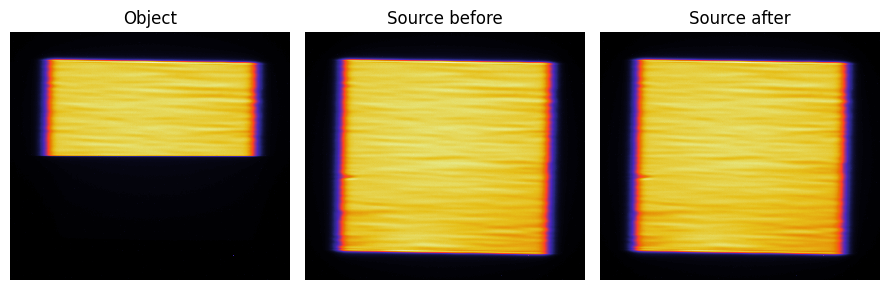

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
file = "step/step_2025/scan"

data_input_object = np.loadtxt(f"test_input/{file}/object.asc")[:, 1:].T
data_input_source_before = np.loadtxt(f"test_input/{file}/back_before.asc")[:, 1:].T
data_input_source_after = np.loadtxt(f"test_input/{file}/back_after.asc")[:, 1:].T

fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].pcolormesh(data_input_object, cmap="CMRmap")
ax[0].axis("off")
ax[0].set_title("Object")

ax[1].pcolormesh(data_input_source_before, cmap="CMRmap")
ax[1].axis("off")
ax[1].set_title("Source before")

ax[2].pcolormesh(data_input_source_after, cmap="CMRmap")
ax[2].axis("off")
ax[2].set_title("Source after")

plt.tight_layout()
plt.show()

# plt.savefig(f"source.png", bbox_inches='tight', pad_inches=0, dpi=400)

### Median filtering of dead pixels

In [2]:
def clean_xray_image_stack(image_stack, median_filter_size=3, threshold_factor=3):
  """
  Очищает стек рентгеновских изображений от аномальных выбросов (горячих пикселей).

  Args:
    image_stack: NumPy массив формы (21, 2048, 2048), представляющий стек рентгеновских изображений.
    median_filter_size: Размер ядра медианного фильтра. Нечетное число, определяющее размер окрестности
                        для вычисления медианного значения.  Типичные значения: 3, 5, 7.
    threshold_factor:  Фактор, определяющий порог для обнаружения выбросов.  Умножается на стандартное отклонение
                       окрестности пикселя.  Более высокое значение делает детектор выбросов менее чувствительным.

  Returns:
    NumPy массив той же формы, что и входной, с очищенными изображениями.
  """

  is_numpy = isinstance(image_stack, np.ndarray)
  xp = np if is_numpy else cp # Выбираем модуль: cupy или numpy
  if is_numpy:
      import scipy.ndimage as ndimage
  else:
      import cupyx.scipy.ndimage as ndimage

  cleaned_stack = xp.zeros_like(image_stack)

  for i in range(image_stack.shape[0]):  # Итерируемся по кадрам
    frame = image_stack[i]

    # 1. Медианный фильтр для начального обнаружения и оценки фона
    #    Медианный фильтр эффективно удаляет выбросы, сохраняя при этом структуру изображения.
    median_filtered = ndimage.median_filter(frame, size=median_filter_size)

    # 2. Вычисление разницы между оригинальным изображением и отфильтрованным
    difference = np.abs(frame - median_filtered)

    # 3. Вычисление стандартного отклонения разницы в окрестности каждого пикселя
    #    Используем фильтр стандартного отклонения.  Можно использовать `scipy.ndimage.generic_filter`
    #    с функцией, вычисляющей стандартное отклонение.  Для простоты можно использовать медианный фильтр
    #    разницы и затем умножить результат на оценочный коэффициент для стандартного отклонения.
    #    Медианный фильтр эффективно сглаживает разницу, обеспечивая оценку локального стандартного отклонения.
    #    Альтернативно, можно использовать свертку с ядром для оценки стандартного отклонения, но это
    #    требует более тщательной настройки параметров ядра.
    std_dev_estimate = ndimage.median_filter(difference, size=median_filter_size) * 1.4826  # 1.4826 приближает std при нормальном распределении

    # 4. Создание маски выбросов
    #    Пиксели, отклоняющиеся от медианного фильтра больше, чем threshold_factor * std_dev_estimate,
    #    считаются выбросами.
    outlier_mask = difference > (threshold_factor * std_dev_estimate)

    # 5. Замена выбросов медианными значениями
    #    Заменяем значения выбросов медианными значениями из отфильтрованного изображения.
    cleaned_frame = frame.copy()  # Создаем копию, чтобы не менять исходный кадр
    cleaned_frame[outlier_mask] = median_filtered[outlier_mask]

    cleaned_stack[i] = cleaned_frame

  return cleaned_stack

data_input_object_corrected = clean_xray_image_stack(data_input_object)
data_input_source_before_corrected = clean_xray_image_stack(data_input_source_before)
data_input_source_after_corrected = clean_xray_image_stack(data_input_source_after)

### Normalizing

--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 0.0000
Центр (mu):                      260499.8293
Ширина (sigma, стандартное откл.):8389.0307
Смещение (C, базовая линия):     0.0000
--------------------------------------------------
--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 0.0000
Центр (mu):                      266572.6522
Ширина (sigma, стандартное откл.):8857.5729
Смещение (C, базовая линия):     0.0000
--------------------------------------------------
--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 0.0000
Центр (mu):                      266683.9176
Ширина (sigma, стандартное откл.):8583.3838
Смещение (C, базовая линия):     0.0000
--------------------------------------------------


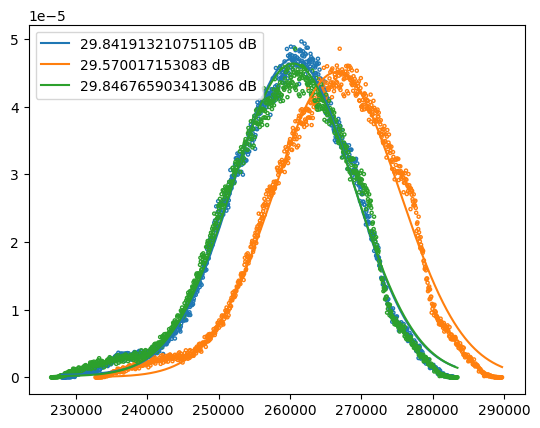

In [3]:
data_object_smooth = data_input_object_corrected[1100:1700, 450:1600]
data_source_before_smooth = data_input_source_before_corrected[1100:1700, 450:1600]
data_source_after_smooth = data_input_source_after_corrected[1100:1700, 450:1600]

from scipy.optimize import curve_fit
bins_num = 1000

hist_object, bin_edges = np.histogram(data_object_smooth, bins=bins_num, density=True)
bin_edges = (bin_edges[1:] + bin_edges[0:-1]) / 2
plt.scatter(bin_edges, hist_object, s=5, facecolors='none', edgecolors='C0')
# plt.hist(obj_med_cutted.flatten(), bins=bins_num, alpha=0.5, density=True, label="object")

hist_source_before, bin_edges_s_before = np.histogram(data_source_before_smooth, bins=bins_num, density=True)
bin_edges_s_before = (bin_edges_s_before[1:] + bin_edges_s_before[0:-1]) / 2
plt.scatter(bin_edges_s_before, hist_source_before, s=5, facecolors='none', edgecolors='C1')
# plt.hist(obj_denoised.flatten(), bins=bins_num, alpha=0.5, density=True, label="source")

hist_source_after, bin_edges_s_after = np.histogram(data_source_after_smooth, bins=bins_num, density=True)
bin_edges_s_after = (bin_edges_s_after[1:] + bin_edges_s_after[0:-1]) / 2
plt.scatter(bin_edges_s_after, hist_source_before, s=5, facecolors='none', edgecolors='C2')


def fit_gaussian(x_data, y_data):
    """
    Аппроксимирует одномерные данные (x_data, y_data) Гауссовой функцией.

    Модель Гаусса: f(x) = A * exp(-(x - mu)^2 / (2 * sigma^2)) + C
    Где:
    - A: Амплитуда (высота пика) Гауссовой кривой, также может рассматриваться как фактор нормировки.
    - mu: Центр (среднее значение) Гауссовой кривой.
    - sigma: Ширина (стандартное отклонение) Гауссовой кривой.
    - C: Смещение (базовая линия).

    Параметры:
    x_data : numpy.ndarray
        Одномерный массив значений по оси X.
    y_data : numpy.ndarray
        Одномерный массив значений по оси Y, соответствующий x_data.

    Возвращает:
    numpy.ndarray
        Массив значений Y, представляющий аппроксимированную Гауссову кривую
        для заданных x_data и найденных параметров.
        Возвращает None, если аппроксимация не удалась.
    """

    # 1. Определяем Гауссову функцию
    # Смещение (offset) добавляется для учета ненулевой базовой линии
    def gaussian(x, amplitude, center, sigma, offset):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2)) + offset

    # 2. Предоставляем начальные догадки для параметров
    # Хорошие начальные догадки помогают curve_fit быстрее и правильнее сойтись.
    amplitude_guess = np.max(y_data) - np.min(y_data) # Примерная амплитуда пика
    center_guess = x_data[np.argmax(y_data)]         # X-координата максимального Y
    sigma_guess = (x_data[-1] - x_data[0]) / 6.0     # Примерная ширина (диапазон / 6)
    offset_guess = np.min(y_data)                     # Примерная базовая линия

    initial_guesses = [amplitude_guess, center_guess, sigma_guess, offset_guess]

    # Ограничения для параметров (опционально, но часто полезно)
    # Например, sigma должна быть положительной, амплитуда может быть положительной/отрицательной
    # center_guess в пределах x_data, offset_guess в пределах y_data
    # bounds = ([min_amplitude, min_center, min_sigma, min_offset],
    #           [max_amplitude, max_center, max_sigma, max_offset])
    # Для sigma точно надо, чтобы была > 0
    bounds = ([-np.inf, x_data.min(), 0.001, -np.inf], # Нижние границы
              [ np.inf, x_data.max(), np.inf,  np.inf]) # Верхние границы


    # 3. Выполняем аппроксимацию
    try:
        # popt - оптимальные параметры, pcov - ковариационная матрица
        popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guesses, bounds=bounds)
    except RuntimeError as e:
        print(f"Ошибка при аппроксимации Гауссовой функцией: {e}")
        print("Попробуйте скорректировать начальные параметры или данные.")
        return None

    # 4. Извлекаем аппроксимированные параметры
    amplitude_fit, center_fit, sigma_fit, offset_fit = popt

    # 5. Выводим параметры через print
    print("--- Параметры аппроксимации Гауссовой кривой ---")
    print(f"Амплитуда (A, фактор нормировки): {amplitude_fit:.4f}")
    print(f"Центр (mu):                      {center_fit:.4f}")
    print(f"Ширина (sigma, стандартное откл.):{sigma_fit:.4f}")
    print(f"Смещение (C, базовая линия):     {offset_fit:.4f}")
    print("--------------------------------------------------")

    # 6. Генерируем аппроксимированную кривую
    fitted_gaussian_curve = gaussian(x_data, *popt)

    return center_fit, sigma_fit, fitted_gaussian_curve

mu_object, sig, hist_approx = fit_gaussian(bin_edges, hist_object)
mu_source_before, sig_den_before, hist_den_approx_before = fit_gaussian(bin_edges_s_before, hist_source_before)
mu_source_after, sig_den_after, hist_den_approx_after = fit_gaussian(bin_edges_s_before, hist_source_after)

def SNR(mu, sig):
    return 20*np.log10(mu/sig)

plt.plot(bin_edges, hist_approx, label=f"{SNR(mu_object, sig)} dB")
plt.plot(bin_edges_s_before, hist_den_approx_before, label=f"{SNR(mu_source_before, sig_den_before)} dB")
plt.plot(bin_edges_s_after, hist_den_approx_after, label=f"{SNR(mu_source_after, sig_den_after)} dB")
plt.legend()

### Data grid initialization and flat field correction of the data

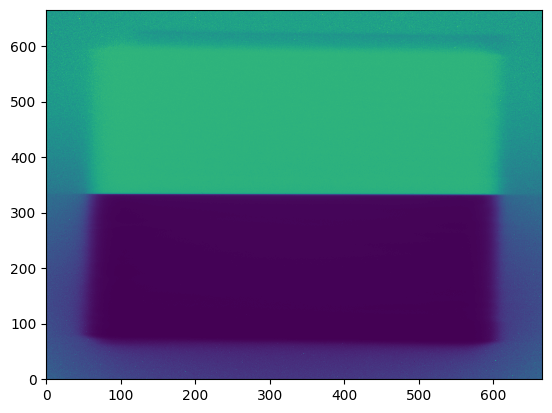

In [4]:
dx_input = 0.325
dy_input = 0.325
Nx, Ny = data_input_object.shape
x_input = np.linspace(0, (Nx-1)*dx_input, Nx)
y_input = np.linspace(0, (Ny-1)*dy_input, Ny)
XX, YY = np.meshgrid(x_input, y_input)

%matplotlib inline
# data_input = data_input_object_rotated/(k*data_input_source_rotated+b)
data_source_prepro = 0.5 * (data_input_source_before_corrected / mu_source_before + data_input_source_after_corrected / mu_source_after)
data_object_prepro = (data_input_object_corrected / mu_object) / data_source_prepro
plt.pcolormesh(x_input, y_input, data_object_prepro)

### Sigma of the noise estimation

--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 80.6897
Центр (mu):                      1.0111
Ширина (sigma, стандартное откл.):0.0051
Смещение (C, базовая линия):     -0.5025
--------------------------------------------------
--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 86.9453
Центр (mu):                      0.0150
Ширина (sigma, стандартное откл.):0.0046
Смещение (C, базовая линия):     0.6668
--------------------------------------------------


143.5744039233893

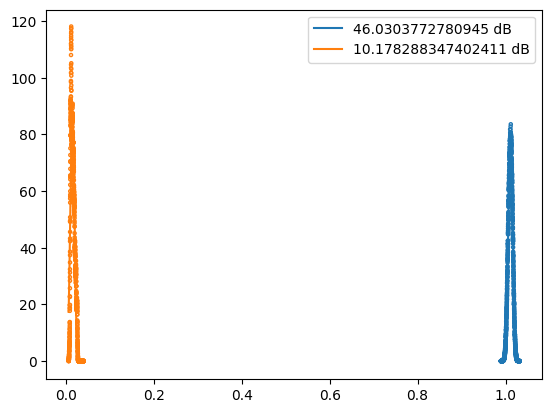

In [5]:
from scipy.optimize import curve_fit
%matplotlib inline
bins_num = 1000

hist, bin_edges = np.histogram(data_object_prepro[1076:1565, 328:1673], bins=bins_num, density=True)
bin_edges = (bin_edges[1:] + bin_edges[0:-1]) / 2
plt.scatter(bin_edges, hist, s=5, facecolors='none', edgecolors='C0')

hist_den, bin_edges_den = np.histogram(data_object_prepro[371:960, 328:1673], bins=bins_num, density=True)
bin_edges_den = (bin_edges_den[1:] + bin_edges_den[0:-1]) / 2
plt.scatter(bin_edges_den, hist_den, s=5, facecolors='none', edgecolors='C1')


def fit_gaussian(x_data, y_data):
    """
    Аппроксимирует одномерные данные (x_data, y_data) Гауссовой функцией.

    Модель Гаусса: f(x) = A * exp(-(x - mu)^2 / (2 * sigma^2)) + C
    Где:
    - A: Амплитуда (высота пика) Гауссовой кривой, также может рассматриваться как фактор нормировки.
    - mu: Центр (среднее значение) Гауссовой кривой.
    - sigma: Ширина (стандартное отклонение) Гауссовой кривой.
    - C: Смещение (базовая линия).

    Параметры:
    x_data : numpy.ndarray
        Одномерный массив значений по оси X.
    y_data : numpy.ndarray
        Одномерный массив значений по оси Y, соответствующий x_data.

    Возвращает:
    numpy.ndarray
        Массив значений Y, представляющий аппроксимированную Гауссову кривую
        для заданных x_data и найденных параметров.
        Возвращает None, если аппроксимация не удалась.
    """

    # 1. Определяем Гауссову функцию
    # Смещение (offset) добавляется для учета ненулевой базовой линии
    def gaussian(x, amplitude, center, sigma, offset):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2)) + offset

    # 2. Предоставляем начальные догадки для параметров
    # Хорошие начальные догадки помогают curve_fit быстрее и правильнее сойтись.
    amplitude_guess = np.max(y_data) - np.min(y_data) # Примерная амплитуда пика
    center_guess = x_data[np.argmax(y_data)]         # X-координата максимального Y
    sigma_guess = (x_data[-1] - x_data[0]) / 10.0     # Примерная ширина (диапазон / 6)
    offset_guess = np.min(y_data)                     # Примерная базовая линия

    initial_guesses = [amplitude_guess, center_guess, sigma_guess, offset_guess]

    # Ограничения для параметров (опционально, но часто полезно)
    # Например, sigma должна быть положительной, амплитуда может быть положительной/отрицательной
    # center_guess в пределах x_data, offset_guess в пределах y_data
    # bounds = ([min_amplitude, min_center, min_sigma, min_offset],
    #           [max_amplitude, max_center, max_sigma, max_offset])
    # Для sigma точно надо, чтобы была > 0
    bounds = ([-np.inf, x_data.min(), 0.001, -np.inf], # Нижние границы
              [ np.inf, x_data.max(), np.inf,  np.inf]) # Верхние границы


    # 3. Выполняем аппроксимацию
    try:
        # popt - оптимальные параметры, pcov - ковариационная матрица
        popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guesses, bounds=bounds)
    except RuntimeError as e:
        print(f"Ошибка при аппроксимации Гауссовой функцией: {e}")
        print("Попробуйте скорректировать начальные параметры или данные.")
        return None

    # 4. Извлекаем аппроксимированные параметры
    amplitude_fit, center_fit, sigma_fit, offset_fit = popt

    # 5. Выводим параметры через print
    print("--- Параметры аппроксимации Гауссовой кривой ---")
    print(f"Амплитуда (A, фактор нормировки): {amplitude_fit:.4f}")
    print(f"Центр (mu):                      {center_fit:.4f}")
    print(f"Ширина (sigma, стандартное откл.):{sigma_fit:.4f}")
    print(f"Смещение (C, базовая линия):     {offset_fit:.4f}")
    print("--------------------------------------------------")

    # 6. Генерируем аппроксимированную кривую
    fitted_gaussian_curve = gaussian(x_data, *popt)

    return center_fit, sigma_fit, fitted_gaussian_curve

mu, sig, hist_approx = fit_gaussian(bin_edges, hist)
mu_den, sig_den, hist_den_approx = fit_gaussian(bin_edges_den, hist_den)

def SNR(mu, sig):
    return 20*np.log10(mu/sig)

%matplotlib inline
plt.plot(bin_edges, hist_approx, label=f"{SNR(mu, sig)} dB")
plt.plot(bin_edges_den, hist_den_approx, label=f"{SNR(mu_den, sig_den)} dB")
plt.legend()
# CNR = (1 - 0.0148) / np.sqrt(0.005**2+0.0046**2)
CNR = (1 - mu_den) / np.sqrt(sig**2+sig_den**2)
CNR

### ROI of the image

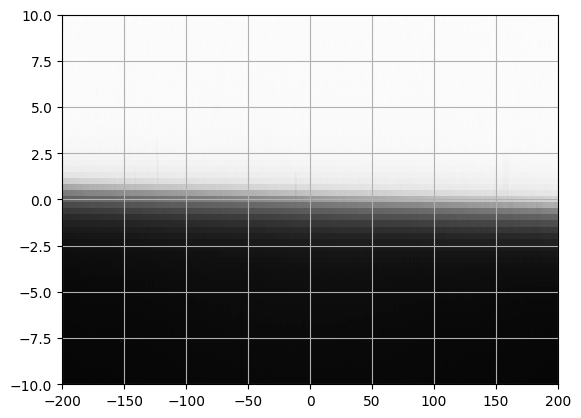

In [6]:
def cut_data(x_input, y_input, data_input, edge_pos, CUT_SIZE=200):
    """
    Вырезает область из двумерного массива `data_input` на основе обрезанных
    координатных массивов `x_input` и `y_input`.

    Args:
        x_input:  Одномерный массив координат x.
        y_input:  Одномерный массив координат y.
        data_input: Двумерный массив данных.  Первая ось соответствует y, вторая - x.
        edge_pos:  Положение края (для центрирования y).
        CUT_SIZE:  Размер вырезаемой области в обе стороны от центра.

    Returns:
        data_cutted:  Вырезанный массив данных.
        x_cut: Вырезанный массив x координат
        y_cut: Вырезанный массив y координат
    """

    # 1. Центрирование координат:
    x_input_shift = x_input - x_input[len(x_input) // 2]
    y_input_shift = y_input - edge_pos

    # 2. Создание масок для выбора индексов:
    x_mask = np.abs(x_input_shift) < CUT_SIZE
    y_mask = np.abs(y_input_shift) < CUT_SIZE

    # 3. Получение обрезанных координат
    x_cut = x_input_shift[x_mask]
    y_cut = y_input_shift[y_mask]

    # 4. Получение индексов для вырезания:
    x_indices = np.where(x_mask)[0]
    y_indices = np.where(y_mask)[0]

    # 5. Вырезание данных:
    # Важно: data_input[rows, cols]
    data_cutted = data_input[y_indices[:, None], x_indices] # Используем numpy advanced indexing

    return data_cutted, x_cut, y_cut

edge_pos = y_input[np.argmax(np.gradient(np.mean(data_object_prepro, axis=1)))]
ROI_image, x_cut, y_cut = cut_data(x_input, y_input, data_object_prepro, edge_pos, CUT_SIZE=200)

%matplotlib inline
plt.pcolormesh(x_cut, y_cut, ROI_image, cmap="Greys_r")
plt.ylim(-10, 10)
plt.grid()

### Modified slanted-edge LSF estimation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, special
from scipy.signal import windows

# -------------------- helpers --------------------

def norm_cdf(x):
    """Standard normal CDF."""
    return 0.5 * (1.0 + special.erf(x / np.sqrt(2.0)))

# -------------------- fitting --------------------

def fit_slanted_edge_2d(x, y, img, sigma=0.5, maxiter=2000):
    """
    Fit model:
      v_fit(x,y) = vL + (vH - vL) * norm_cdf( (x - (mu + alpha*y)) / sigma )
    x, y, img : 2D arrays of same shape
    Returns dict with fitted parameters: alpha, mu, vH, vL
    """
    x_flat = x.ravel().astype(float)
    y_flat = y.ravel().astype(float)
    v_flat = img.ravel().astype(float)

    vL0, vH0 = np.percentile(v_flat, [5, 95])
    mu0 = np.median(x_flat)
    alpha0 = 0.0

    def model(params):
        alpha, mu, vH, vL = params
        arg = (x_flat - (mu + alpha * y_flat)) / sigma
        return vL + (vH - vL) * norm_cdf(arg)

    def residuals(params):
        return model(params) - v_flat

    p0 = np.array([alpha0, mu0, vH0, vL0], dtype=float)
    res = optimize.least_squares(residuals, p0, max_nfev=maxiter, xtol=1e-8, ftol=1e-8)
    alpha, mu, vH, vL = res.x
    print({"alpha": float(alpha), "mu": float(mu), "vH": float(vH), "vL": float(vL), "success": bool(res.success)})
    return {"alpha": float(alpha), "mu": float(mu), "vH": float(vH), "vL": float(vL), "success": bool(res.success)}

# -------------------- projection & binning --------------------

def project_and_bin(x, y, img, fit_params, binn=8, pad_bins=3.0):
    """
    Project pixels onto axis perpendicular to the fitted edge and bin.
    Returns: centers (x positions, pixels), profile (average brightness)
    """
    alpha = fit_params["alpha"]
    mu = fit_params["mu"]

    s = (x - (mu + alpha * y)).ravel().astype(float)  # coordinate along normal (pixels)
    vals = img.ravel().astype(float)

    bin_width = 1.0 / float(binn)
    s_min, s_max = s.min(), s.max()
    edges = np.arange(s_min - pad_bins, s_max + pad_bins + bin_width, bin_width)
    inds = np.digitize(s, edges) - 1
    nbins = len(edges) - 1

    sums = np.zeros(nbins, dtype=float)
    counts = np.zeros(nbins, dtype=int)
    for i, v in enumerate(vals):
        idx = inds[i]
        if 0 <= idx < nbins:
            sums[idx] += v
            counts[idx] += 1

    centers = edges[:-1] + bin_width / 2.0
    profile = np.zeros_like(centers)
    nonzero = counts > 0
    profile[nonzero] = sums[nonzero] / counts[nonzero]

    nz_idx = np.where(nonzero)[0]
    if nz_idx.size == 0:
        raise RuntimeError("No valid bins found.")
    first, last = nz_idx[0], nz_idx[-1]
    return centers[first:last+1], profile[first:last+1]

# -------------------- LSF computation --------------------

def compute_lsf(edge_centers, edge_profile):
    """
    Compute line spread function (LSF) as derivative of edge profile.
    Returns: x_lsf (positions, pixels), lsf (normalized)
    """
    d = float(edge_centers[1] - edge_centers[0])
    lsf = np.gradient(edge_profile, d)
    # center and normalize LSF
    lsf /= np.max(np.abs(lsf))
    return edge_centers, lsf

# -------------------- high-level function --------------------

def estimate_lsf_from_arrays(x, y, img, binn=8, show_plot=True):
    """
    Main pipeline: fit slanted edge, form edge profile, compute LSF.
    x, y, img — 2D arrays of same shape.
    Returns: x_lsf (pixels), lsf (normalized), and dict with details.
    """
    x, y = np.meshgrid(x, y)
    fit = fit_slanted_edge_2d(x, y, img)
    centers, profile = project_and_bin(x, y, img, fit, binn=binn)
    x_lsf, lsf = compute_lsf(centers, profile)

    if show_plot:
        plt.figure(figsize=(6,4))
        plt.plot(x_lsf, lsf, lw=1.8)
        plt.xlabel("Position (pixels)")
        plt.ylabel("LSF (normalized)")
        plt.title("Line Spread Function (modified slanted-edge method)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    details = {"fit": fit, "edge_centers": centers, "edge_profile": profile}
    return x_lsf, lsf, profile, details

# -------------------- example usage --------------------

y_lsf, lsf, esf, details = estimate_lsf_from_arrays(y_cut, x_cut, ROI_image.T, binn=6, show_plot=False)

print("Returned LSF length:", len(lsf))
print("x range:", y_lsf[0], "to", y_lsf[-1])

{'alpha': -0.0026063839897388246, 'mu': -0.04963143682842222, 'vH': 1.009471551765435, 'vL': 0.019968860464933003, 'success': True}
Returned LSF length: 2405
x range: -200.26298622978746 to 200.40368043685643


### Estimated LSF

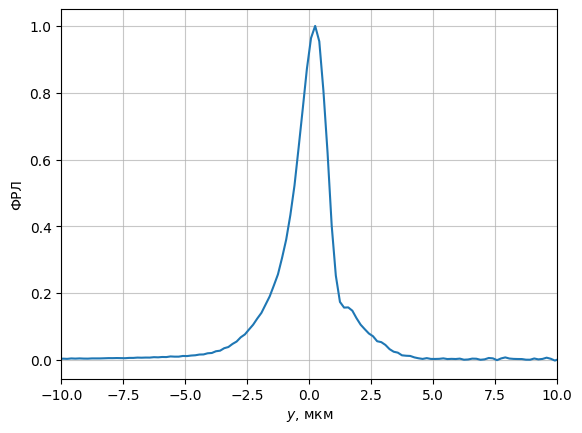

In [8]:
%matplotlib inline
# MTF_approx_neg = approx_copy(laplace_gauss, f_neg, MTF_neg)
# plt.figure(figsize=(4, 2.5), dpi=400)
# plt.scatter(f[f>=0], MTF[f>=0], s=10, alpha=0.3, label="experiment data", facecolors='none', edgecolors='k')
# plt.plot(f[f>=0], MTF[f>=0],  'k')
plt.plot(y_lsf, lsf, label="approximation")
plt.xlim(-10, 10)
# plt.legend()
# plt.xlabel(f"Spatial frequency, cycles/μm")
plt.xlabel(f"$y$, мкм")
# plt.ylabel(f"MTF")
plt.ylabel("ФРЛ")
plt.grid(alpha=0.7)
# plt.yscale("log")
# plt.xscale("log")
# plt.plot(f_neg, MTF_approx_neg)
# plt.plot(f, abs(MTF_approx-MTF))

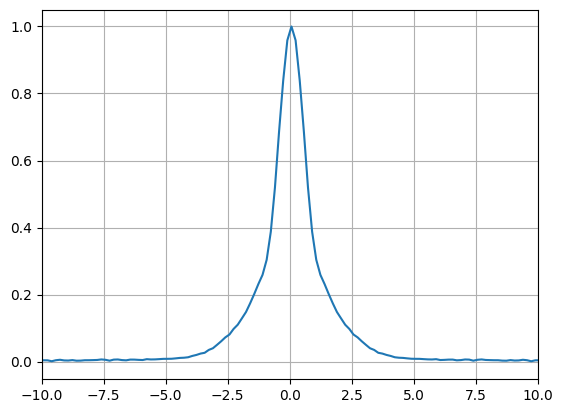

In [72]:
%matplotlib inline
# plt.plot(y_lsf, np.roll(lsf, -1))
plt.plot(y_lsf, (np.roll(lsf, -1) + np.roll(lsf, -1)[::-1])/2)
plt.xlim(-10, 10)
plt.grid()
# plt.plot(y_lsf, lsf[::-1])
# plt.plot(y_lsf, (lsf + lsf[::-1])/2)

fit parameters = [4.09597402 1.03270765]


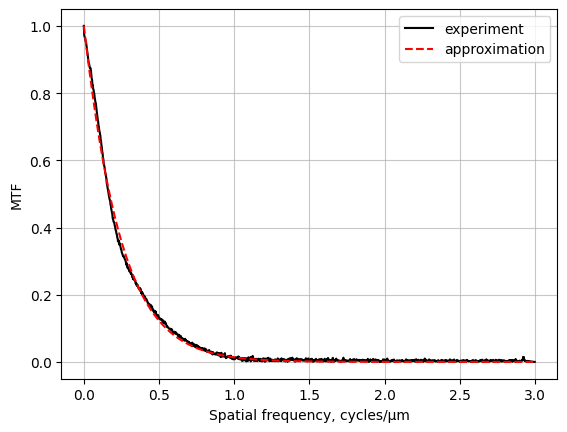

In [82]:
def lsf_to_mtf(lsf, dx):
    f = np.fft.rfftfreq(n=len(lsf), d=dx)
    # MTF = abs(np.fft.rfft(lsf).real)
    MTF = abs(np.fft.rfft(lsf))
    MTF /= MTF[0]
    return f, MTF


f, MTF = lsf_to_mtf(lsf, dx=y_lsf[1]-y_lsf[0])
# f, MTF = lsf_to_mtf((np.roll(lsf, -1) + np.roll(lsf, -1)[::-1])/2, dx=y_lsf[1]-y_lsf[0])
# f, MTF = lsf_to_mtf(np.roll(lsf, -1), dx=y_lsf[1]-y_lsf[0])

from scipy.optimize import curve_fit

def approx_copy(approximation_function, x_data, y_data):
  """
  Создает функцию с аппроксимированными параметрами на основе заданной функции аппроксимации и данных.

  Args:
    approximation_function: Функция аппроксимации, где первый аргумент - x, а остальные - параметры аппроксимации.
    x_data: Массив значений x.
    y_data: Массив значений y.

  Returns:
    Функцию, которая принимает x и возвращает аппроксимированное значение y.
  """

  # Оптимизируем параметры аппроксимации с помощью curve_fit.
  # initial_guess (p0) задавать необязательно, но часто полезно для устойчивости и скорости сходимости
  try:
    popt, pcov = curve_fit(approximation_function, x_data, y_data)
  except RuntimeError:
    print("Оптимизация не сошлась. Попробуйте предоставить initial_guess (p0) для curve_fit.")
    return None
  
  print(f"fit parameters = {popt}")

  return approximation_function(x_data, *popt)

def laplace_gauss(f, a, b):
    # a = 0
    # b = 0
    return np.exp(-(abs(a) * abs(f))**b)

%matplotlib inline
MTF_approx = approx_copy(laplace_gauss, f, MTF)
# MTF_approx_neg = approx_copy(laplace_gauss, f_neg, MTF_neg)

# plt.figure(figsize=(4, 2.5), dpi=400)
# plt.scatter(f[f>=0], MTF[f>=0], s=10, alpha=1, label="experiment data", facecolors='none', edgecolors='k')
# plt.plot(f[f>=0], MTF[f>=0],'k', label="эксперимент")
plt.plot(f, MTF,'k', label="experiment")
# plt.plot(f[f>=0], MTF_approx[f>=0], "r--", label="аппроксимация")
plt.plot(f, MTF_approx, "r--", label="approximation")
plt.legend()
# plt.xlabel(f"Пространственная частота, циклов/мкм")
plt.xlabel(f"Spatial frequency, cycles/μm")
# plt.ylabel(f"MTF")
# plt.ylabel("МПФ")
plt.ylabel("MTF")
plt.grid(alpha=0.7)
# plt.yscale("log")
# plt.xscale("log")